# Foundation+YSE z-band Mass Step Analysis

In this notebook, we re-create the sample and figures from the z-band mass step analysis in Hayes+25. If you find this resource or the associated paper useful for your work, please cite: .

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import extinction
import corner

from py import utils

plt.style.use('./stylesheet/zband.mplstyle')

In [2]:
# Read data table and apply default cuts, as specified in Hayes+25
full_data = at.Table.read('../tables/mnras_table.txt', format='ascii')
sample = utils.apply_data_cuts(full_data, print_summary=True)

Total Spec Sample:               517 (YSE: 292, Foundation: 225)
Normal Ias:                      446 (YSE: 266, Foundation: 180)
0.015 < z < 0.1:                 347 (YSE: 185, Foundation: 162)
(z < 0.08 for Foundation)
gri Data Requirement:            234 (YSE: 119, Foundation: 115)
z-band Data Requirement:         171 (YSE: 57, Foundation: 114)
Reduced Chi Squared < 3:         165 (YSE: 54, Foundation: 111)
T0 Cut:                          151 (YSE: 46, Foundation: 105)
Av < 1:                          151 (YSE: 46, Foundation: 105)
-1.5 < theta < 3:                150 (YSE: 45, Foundation: 105)
Host Mass Estimate:              150 (YSE: 45, Foundation: 105)

Final Sample:                    150 (YSE: 45, Foundation: 105)
* For complete description of the default data cuts, see Hayes+2024.


## Mass Step with Single $R_{V}$

Compute the mass step using the `compute_mass_step` function. This notebook will re-create versions of Figures 7 & 8 from Hayes+25.

In [3]:
# Get the model distance moduli based on the fiducial cosmology
H0 = 73.24  # km/s/Mpc
Omega_m = 0.28
redshift_final, mu_LCDM = utils.model_for_plotting(sample['REDSHIFT_FINAL'], H0=H0, Omega_m=Omega_m)
M_split = 10.

# Compute the uncertainty due to peculiar velocities 
sigma_pec = 150 # km/s
sigma = utils.get_peculiar_velocity_unc(redshift_final, sigma_z=sample['SIGMA_Z'], sigma_pec=sigma_pec)

# Compute the extinction magnitude in the z-band to correct the distance modulus from the z-band only fit for dust
# We use Av from the fit to the optical only data to avoid double-counting the z-band data in the distance modulus result.
z_wave = 8600 #AA
ext_mag = np.zeros(len(sample))
for r, row in enumerate(sample):
    ext_mag[r] = extinction.fitzpatrick99(np.array([z_wave]), a_v = row['GRIZ_AV'], r_v=2.610)[0]

x = sample['LOG_HOSTMASS']                              # Our x-values are the SN host galaxy masses.
y = sample['Z_MU'] - mu_LCDM - ext_mag                  # Our y-values are the dust-corrected z-band Hubble residuals.
                                                        # If you use the griz Hubble residuals or the gri Hubble residuals,
                                                        # remove the ext_mag correction!
yerr = np.sqrt(sample['Z_MU_ERR']**2 + sigma**2)        # Our y-errors include contributions from the fit and PV uncertainty.
                                                        # The sampler will add in quadrature the residual scatter term when fitting
                                                        # for this parameter in each mass bin.

In [4]:
# Run the mass step sampler, implemented in Numpyro
# You can adjust the sampler kwargs (see https://num.pyro.ai/en/stable/mcmc.html for more information) with the hmc_kwargs parameter
sampler = utils.compute_mass_step(x, y, yerr, hmc_kwargs={'num_chains': 1}, M_split=M_split, survey_mask=survey_mask)
samples = sampler.get_samples()
sampler.print_summary()

# Put the samples for the parameters of interest into a dictionary for plotting
samples_dict = {'gamma': samples['gamma'],
                'sigma_res_HM_Foundation': np.sqrt(samples['sigma_2_res_HM_Foundation']),
                'sigma_res_HM_YSE': np.sqrt(samples['sigma_2_res_HM_YSE']),
                'sigma_res_LM_Foundation': np.sqrt(samples['sigma_2_res_LM_Foundation']),
                'sigma_res_LM_YSE': np.sqrt(samples['sigma_2_res_LM_YSE'])}

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


sample: 100%|██████████| 20000/20000 [00:04<00:00, 4210.35it/s, 15 steps of size 3.98e-01. acc. prob=0.92]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                   delta_LM      0.10      0.03      0.10      0.06      0.14   8582.78      1.00
                      gamma     -0.11      0.03     -0.11     -0.15     -0.05   8732.83      1.00
  sigma_2_res_HM_Foundation      0.01      0.00      0.01      0.01      0.02  14631.64      1.00
         sigma_2_res_HM_YSE      0.08      0.03      0.07      0.04      0.12  12737.71      1.00
  sigma_2_res_LM_Foundation      0.02      0.01      0.02      0.01      0.03  13089.59      1.00
         sigma_2_res_LM_YSE      0.02      0.02      0.01      0.00      0.04  16167.74      1.00

Number of divergences: 0


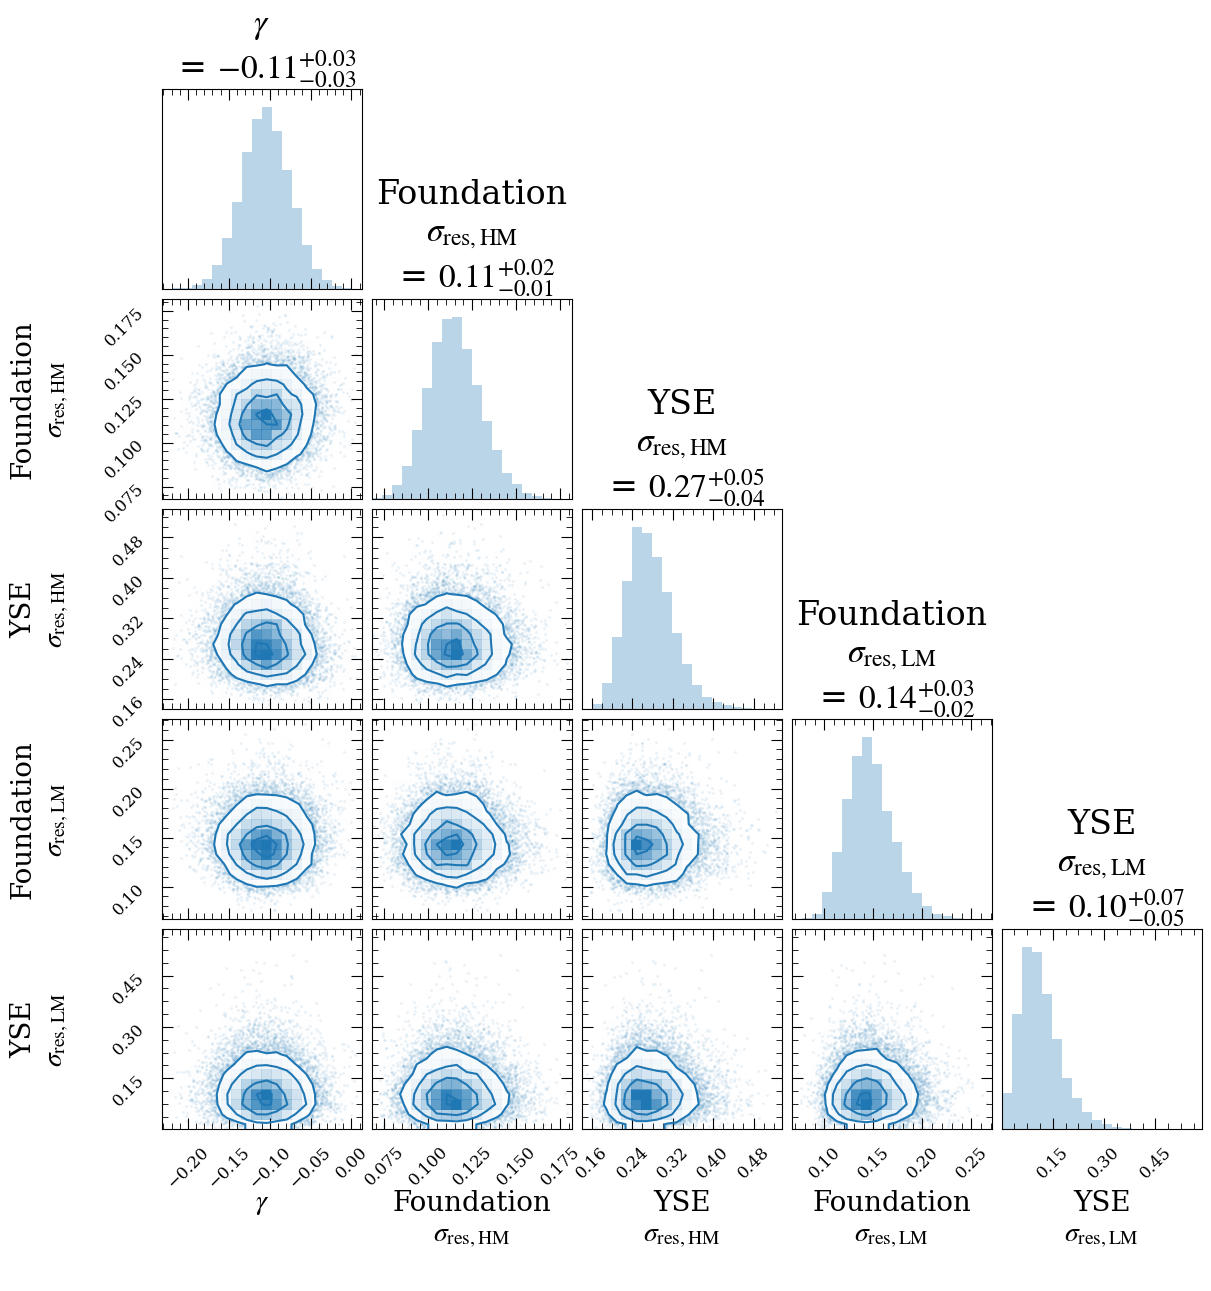

In [5]:
# Show the corner plot for the mass step parameters
fig = corner.corner(samples_dict, color='tab:blue', show_titles=True,
                    hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                    labels=['$\\gamma$\n', 'Foundation\n$\\sigma_{\\rm{res, HM}}$\n', 'YSE\n$\\sigma_{\\rm{res, HM}}$\n',
                            'Foundation\n$\\sigma_{\\rm{res, LM}}$\n', 'YSE\n$\\sigma_{\\rm{res, LM}}$\n'])

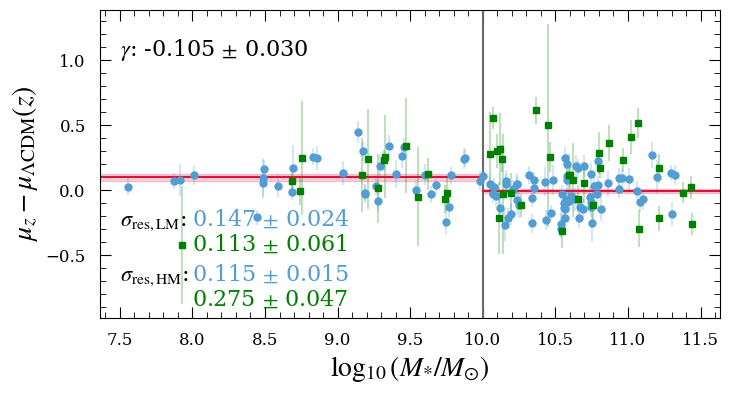

In [6]:
# Plot the Hubble residuals vs host galaxy mass with the fitted mean Hubble residuals in the LM/HM bins and the residual scatter shown
# As with the Hubble diagram, the kwarg dust_corrected will correct the distance modulus from a single band fit for dust.
# Note that the listed uncertainty on the mass step does not include a contribution from
# systematic uncertainty arising from host galaxy mass uncertainties
fig, ax = utils.plot_mass_step(sample, fit_filters='z', dust_corrected=True, M_split=M_split, samples=samples)

## Mass Step with Split $R_{V}$

Compute the mass step assuming different values of $R_{V}$ for SNe Ia in high mass and low mass host galaxies. For high mass host galaxies, we assume $R_{V} = 2.39$ and for low mass host galaxies, we assume $R_{V} = 3.14$. These values of $R_{V}$ are as reported in Graying+2024.

In [7]:
# Get the model distance moduli based on the fiducial cosmology
H0 = 73.24  # km/s/Mpc
Omega_m = 0.28
redshift_final, mu_LCDM = utils.model_for_plotting(sample['REDSHIFT_FINAL'], H0=H0, Omega_m=Omega_m)
M_split = 10.

# Get the host galaxy masses and create a mask to differentiate high and low mass hosts
x = sample['LOG_HOSTMASS']
mass_mask = x < M_split

# Compute the uncertainty due to peculiar velocities 
sigma_pec = 150 # km/s
sigma = utils.get_peculiar_velocity_unc(redshift_final, sigma_z=sample['SIGMA_Z'], sigma_pec=sigma_pec)

# Get copies of the z-band distance modulus estimates for both choices of Rv, so that we do not edit the values in the table
highrv_copy = np.copy(np.array(sample['Z_MU'].value))
highrv_err_copy = np.copy(np.array(sample['Z_MU_ERR'].value))

lowrv_copy = np.copy(np.array(sample['Z_MU'].value))
lowrv_err_copy = np.copy(np.array(sample['Z_MU_ERR'].value))

# Mask the high/low Rv columns based on the mass mask
highrv_copy[~mass_mask] = 0
lowrv_copy[mass_mask] = 0
highrv_err_copy[~mass_mask] = 0
lowrv_err_copy[mass_mask] = 0

# Compute the extinction magnitude in the z-band to correct the distance modulus from the z-band only fit for dust for both choices of Rv
z_wave = 8600 #AA
highRV_ext_mag = np.zeros(len(sample))
for r, row in enumerate(sample):
    highRV_ext_mag[r] = extinction.fitzpatrick99(np.array([z_wave]), a_v = row['HIGHRV_GRIZ_AV'], r_v=3.14)[0]
highRV_ext_mag[~mass_mask] = 0.

lowRV_ext_mag = np.zeros(len(sample))
for r, row in enumerate(sample):
    lowRV_ext_mag[r] = extinction.fitzpatrick99(np.array([z_wave]), a_v = row['LOWRV_GRIZ_AV'], r_v=2.39)[0]
lowRV_ext_mag[mass_mask] = 0.

y = highrv_copy + lowrv_copy - mu_LCDM - highRV_ext_mag - lowRV_ext_mag     # Our y-values are the dust-corrected z-band Hubble residuals.
                                                                            # If you use the gri Hubble residuals, remove the ext_mag correction!
yerr = np.sqrt(highrv_err_copy**2 + lowrv_err_copy**2 + sigma**2)           # Our y-errors include contributions from the fit and PV uncertainty.
                                                                            # The sampler will add in quadrature the residual scatter term when fitting
                                                                            # for this parameter in each mass bin.

In [8]:
# Run the mass step sampler
sampler = utils.compute_mass_step(x, y, yerr, hmc_kwargs={'num_chains': 1}, M_split=M_split, survey_mask=survey_mask)
samples = sampler.get_samples()
sampler.print_summary()

# Put the samples for the parameters of interest into a dictionary for plotting
samples_dict = {'gamma': samples['gamma'],
                'sigma_res_HM_Foundation': np.sqrt(samples['sigma_2_res_HM_Foundation']),
                'sigma_res_HM_YSE': np.sqrt(samples['sigma_2_res_HM_YSE']),
                'sigma_res_LM_Foundation': np.sqrt(samples['sigma_2_res_LM_Foundation']),
                'sigma_res_LM_YSE': np.sqrt(samples['sigma_2_res_LM_YSE'])}

  0%|          | 0/20000 [00:00<?, ?it/s]

sample: 100%|██████████| 20000/20000 [00:04<00:00, 4231.57it/s, 15 steps of size 3.61e-01. acc. prob=0.94]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                   delta_LM      0.09      0.03      0.09      0.05      0.13   9619.38      1.00
                      gamma     -0.09      0.03     -0.09     -0.14     -0.04   9520.24      1.00
  sigma_2_res_HM_Foundation      0.01      0.00      0.01      0.01      0.02  13695.86      1.00
         sigma_2_res_HM_YSE      0.08      0.03      0.07      0.04      0.12  12128.32      1.00
  sigma_2_res_LM_Foundation      0.02      0.01      0.02      0.01      0.03  12660.76      1.00
         sigma_2_res_LM_YSE      0.02      0.02      0.01      0.00      0.04  15682.02      1.00

Number of divergences: 0


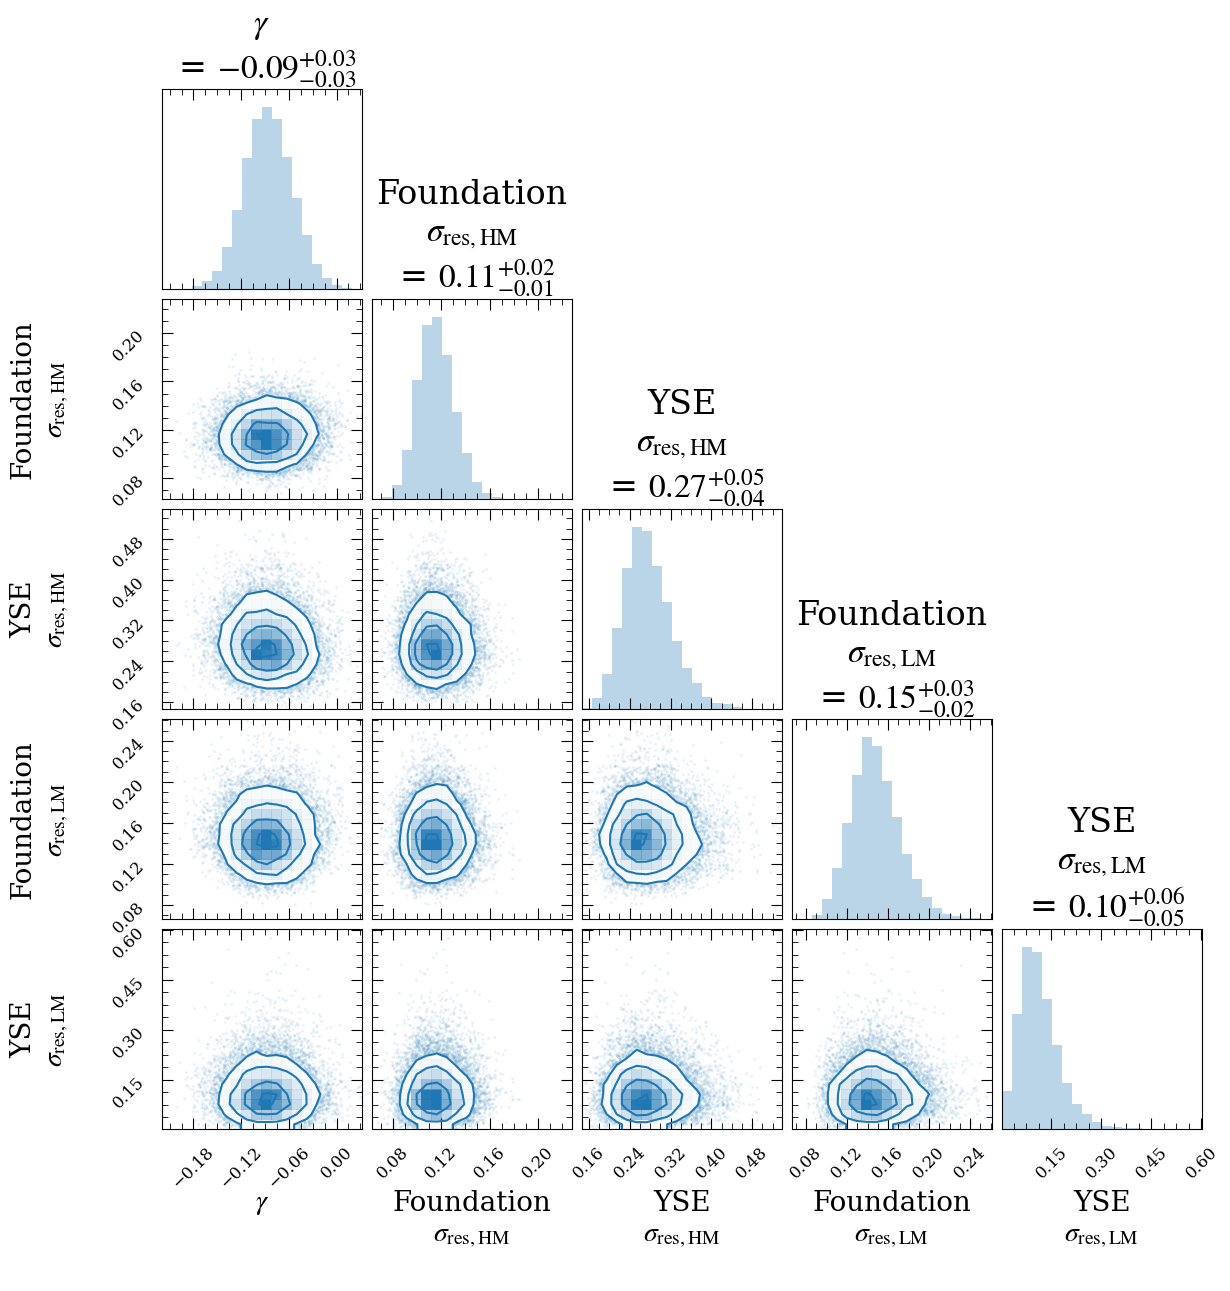

In [9]:
# Show the corner plot for the mass step parameters
fig = corner.corner(samples_dict, color='tab:blue', show_titles=True,
                    hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                    labels=['$\\gamma$\n', 'Foundation\n$\\sigma_{\\rm{res, HM}}$\n', 'YSE\n$\\sigma_{\\rm{res, HM}}$\n',
                            'Foundation\n$\\sigma_{\\rm{res, LM}}$\n', 'YSE\n$\\sigma_{\\rm{res, LM}}$\n'])